In [21]:
import pickle
import numpy as np
from scipy.ndimage import gaussian_filter
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import itertools
import operator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
from l0bnb import fit_path
import seaborn as sns
import pandas as pd

In [55]:
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['figure.titlesize'] = 30
sns.set(font_scale=2.0)

In [23]:
import pandas as pd
data_path = './cpfr/'

In [24]:
def load_data(file, X, T):
    """
    This function loads the data.

    Inputs:
        file    :    CSV file of shape (X, T) of the non-dimensional length and time. Take 0 <= X, T <= 1.
    
    Returns:
        u       :    Numpy Array of shape (T, X) of the data
        x       :    Numpy Array of shape (X,)
        t       :    Numpy Array of shape (T,)
        dx      :    1/400
        dt      :    1/300
    """
    file_to_read = pd.read_csv(file, index_col=False, header=None)
    u = np.array(file_to_read)
    x = np.linspace(0, 1, X)
    t = np.linspace(0, 1, T)

    return u, x, t

In [25]:
def smooth(u,x,t,sigma=6):
    """
    This function smooths the u matrix while keeping x and t the same.

    Inputs:
    u: The u matrix that is to be smoothed
    x: x values
    t: t values
    n: number of times initial gaussian filter is to be applied
    sigma: sigma value to be used in the initial gaussian filter
    m: number of times we need to perform KNN_Gaussian
    sigma_k: sigma_k[i][0] refers to the sigma value in the first gaussian filter of KNN_Gaussian for ith execution of KNN_Gaussian
             sigma_k[i][1] refers to the num of neighbours in the KNN regression of KNN_Gaussian for ith execution of KNN_Gaussian
             sigma_k[i][2] refers to the sigma value in the second gaussian filter of KNN_Gaussian for ith execution of KNN_Gaussian

    Output: 
    The smoothed u matrix
    """
    u_cap=gaussian_filter(u,sigma=sigma)
    print(np.std(u_cap), np.std(u))
    return u_cap


In [26]:
def derivatives(u,x,t,deg=3,width=9):
    """

    Finds the derivatives of u numerically using polynomial interpolation

    Inputs:
    u=u matrix
    x=x values
    t=t values
    deg=degree of the polynomial in polynomial interpolation
    width=no of points that are considered for interpolation (should be odd)

    Outputs:
    u = u matrix without the boundary points
    ut = time derivative of u
    ux = space derivative of u
    uxx = 2nd space derivative of u

    """
    if width%2==0:
        return "Error: Width to be used in polynomial interpolation should be odd so that we split the left and right points evenly"

    t_leni,x_leni = u.shape
    t_len=t_leni-(width)+1 # t_len and x_len decreases because we neglect the terms at the end
    x_len=x_leni-(width)+1 

    ut = np.zeros((t_len,x_len))
    ux = np.zeros((t_len,x_len))
    uxx = np.zeros((t_len,x_len))
    uxxx = np.zeros((t_len,x_len))
    w=width//2  # number of points taken on each side
    for i in range(x_len):
        ut[:,i] = interpolate(u[:,i+w], t, diff=1,deg=deg,width=width)[:,0]
    for i in range(t_len):
        der=interpolate(u[i+w,:], x, diff=3,deg=deg,width=width)
        ux[i,:] = der[:,0]
        uxx[i,:] = der[:,1]
        uxxx[i,:] = der[:,2]
    u=u[w:t_leni-w,w:x_leni-w]

    ut = np.reshape(ut, ((t_len)*(x_len),1), order='F')
    ux = np.reshape(ux,  ((t_len)*(x_len),1), order='F')
    uxx = np.reshape(uxx,  ((t_len)*(x_len),1), order='F')
    uxxx = np.reshape(uxxx,  ((t_len)*(x_len),1), order='F')
    return u,ut,ux,uxx,uxxx

In [27]:
def interpolate(u,x,deg,width,diff):    
    """
    u = values of a function
    x = x-coordinates where values are known
    deg=degree of the polynomial in polynomial interpolation
    width=no of points that are considered for interpolation (is odd)
    diff=max order of derivative to be calculated
    """
    
    u = u.flatten()
    x = x.flatten()

    n = len(x)
    du = np.zeros((n - width+1,diff))
    w=width//2
    
    for j in range(w, n-w):
        points = np.arange(j - w, j + w+1)
        # Polynomial interpolation: Least-squares fit
        poly = np.polynomial.polynomial.Polynomial.fit(x[points],u[points],deg)
        # Taking derivatives
        for d in range(1,diff+1):
            du[j-w, d-1] = poly.deriv(m=d)(x[j])
    return du


In [37]:
def library(ct, c1, c1x, c1xx, c1xxx, c2, c2x, c2xx, c2xxx, c3, c3x, c3xx, c3xxx, poly_deg):
    """
    Builds the library of terms
    """
    num_points = ct.shape[0]
    X_ders = np.hstack([np.ones((num_points ,1)), c1x, c2x, c3x, c1xx, c2xx, c3xx, c1xxx, c2xxx, c3xxx])
    X_data = np.hstack([np.reshape(c1, (num_points, 1), order='F'), np.reshape(c2, (num_points, 1), order='F'), np.reshape(c3, (num_points, 1), order='F')])
    derivatives_description = ['','$C_{A, x}$','$C_{B, x}$', '$C_{C, x}$', '$C_{A, xx}$','$C_{B, xx}$', '$C_{C, xx}$', '$C_{A, xxx}$','$C_{B, xxx}$', '$C_{C, xxx}$']
    X, descr = build_Theta(X_data, X_ders, derivatives_description, P = poly_deg, data_description = ['$C_{A}$', '$C_{B}$', '$C_{C}$'])  # Note that here we can add other terms like |u| if we want
    y = ct.reshape(ct.shape[0])
    return X,y,descr

In [29]:
def build_Theta(data, derivatives, derivatives_description, P, data_description = None):
    """
    
    DIRECTLY TAKEN FROM PDE-FIND

    builds a matrix with columns representing polynoimials up to degree P of all variables

    This is used when we subsample and take all the derivatives point by point or if there is an 
    extra input (Q in the paper) to put in.

    input:
        data: column 0 is U, and columns 1:end are Q
        derivatives: a bunch of derivatives of U and maybe Q, should start with a column of ones
        derivatives_description: description of what derivatives have been passed in
        P: max power of polynomial function of U to be included in Theta

    returns:
        Theta = Theta(U,Q)
        descr = description of what all the columns in Theta are
    """
    
    n,d = data.shape
    m, d2 = derivatives.shape
    if n != m: raise Exception('dimension error')
    if data_description is not None: 
        if len(data_description) != d: raise Exception('data descrption error')
    
    # Create a list of all polynomials in d variables up to degree P
    rhs_functions = {}
    f = lambda x, y : np.prod(np.power(list(x), list(y)))
    powers = []            
    for p in range(1,P+1):
            size = d + p - 1
            for indices in itertools.combinations(range(size), d-1):
                starts = [0] + [index+1 for index in indices]
                stops = indices + (size,)
                powers.append(tuple(map(operator.sub, stops, starts)))
    for power in powers: rhs_functions[power] = [lambda x, y = power: f(x,y), power]

    # First column of Theta is just ones.
    Theta = np.ones((n,1))
    descr = ['']
    
    # Add the derivaitves onto Theta
    for D in range(1,derivatives.shape[1]):
        Theta = np.hstack([Theta, derivatives[:,D].reshape(n,1)])
        descr.append(derivatives_description[D])
        
    # Add on derivatives times polynomials
    for D in range(derivatives.shape[1]):
        for k in rhs_functions.keys():
            func = rhs_functions[k][0]
            new_column = np.zeros((n,1))
            for i in range(n):
                new_column[i] = func(data[i,:])*derivatives[i,D]
            Theta = np.hstack([Theta, new_column])
            if data_description is None: descr.append(str(rhs_functions[k][1]) + derivatives_description[D])
            else:
                function_description = ''
                for j in range(d):
                    if rhs_functions[k][1][j] != 0:
                        if rhs_functions[k][1][j] == 1:
                            function_description = function_description + data_description[j]
                        else:
                            function_description = function_description + data_description[j] + '^' + str(rhs_functions[k][1][j])
                descr.append(function_description + derivatives_description[D])

    return Theta, descr

In [30]:
def return_pde(w, rhs_description, ut = 'u_t'):
    pde = ut + ' = '
    first = True
    for i in range(len(w)):
        if w[i] != 0:
            if not first:
                pde = pde + ' + '
            pde = pde + "(%05f)" % (w[i].real) + rhs_description[i] 
            first = False
    return pde


In [58]:
def heatplot(X, y, desc):
    Z = np.hstack([X[:, 1:]])
    Xs = StandardScaler().fit_transform(Z)
    corr = np.corrcoef(Xs.T)
    plt.figure(figsize=(20, 20))
    sns.heatmap(np.round(np.abs(corr), 2), cmap='coolwarm', xticklabels=desc[1:], yticklabels=desc[1:], annot_kws={"fontsize":40})
    plt.title("Correlation Heatmap of Concentrations and their Derivatives (No Noise)", pad=10)
    #plt.savefig('heatmap.png', bbox_inches='tight')
    #plt.savefig('heatmap.svg', bbox_inches='tight')
    plt.show()

In [32]:
def discover_pde_u(u1, u2, u3, x, t, sigma, deg, width, lambda_2, pdeg, max_nzeros, flag=0):
    u1_approx = smooth(u1,x,t,sigma)
    u2_approx = smooth(u2,x,t,sigma)
    u3_approx = smooth(u3,x,t,sigma)
    u1,u1t,u1x,u1xx,u1xxx = derivatives(u1_approx, x, t, deg, width)
    u2,u2t,u2x,u2xx,u2xxx = derivatives(u2_approx, x, t, deg, width)
    u3,u3t,u3x,u3xx,u3xxx = derivatives(u3_approx, x, t, deg, width)
    X,y,descr = library(u3t, u1, u1x, u1xx, u1xxx, u2, u2x, u2xx, u2xxx, u3, u3x, u3xx, u3xxx, pdeg)
    if flag == 1:
        heatplot(X, y, descr)
    sols = fit_path(X,y, lambda_2, max_nonzeros = max_nzeros, intercept=False)
    return sols,descr, X, y, u2t, u3t

In [56]:
X = 200
T = 200
c1, x, t = load_data(data_path + 'A_200.csv', X, T)
c2, x, t = load_data(data_path + 'B_200.csv', X, T)
c3, x, t = load_data(data_path + 'C_200.csv', X, T)

sols, descr, X, y1, y2, y3 = discover_pde_u(c1, c2, c3, x, t, 6, 3, 9, 1e-2, 1, 5)

for i in range(len(sols)):
    print(return_pde(sols[i]["B"], descr))

1.2162988332552953 1.2529147442093735
1.5865953375593949 1.6294475659861594
0.3769778940189613 0.3836974322788996
Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  4
Iteration: 4. Number of non-zeros:  5
u_t = (0.348757)$C_{B}$
u_t = (0.418508)$C_{B}$ + (0.238357)$C_{C}$$C_{B, x}$
u_t = (1.829763) + (-2.172676)$C_{C, x}$ + (-1.057910)$C_{C}$ + (0.502210)$C_{B}$
u_t = (1.292939) + (-2.113956)$C_{C, x}$ + (-0.939704)$C_{C}$ + (0.602652)$C_{B}$ + (0.000071)$C_{B}$$C_{A, xxx}$


# SNR = 10^3

In [13]:
X = 200
T = 200
c1, x, t = load_data(data_path + 'A_200.csv', X, T)
c2, x, t = load_data(data_path + 'B_200.csv', X, T)
c3, x, t = load_data(data_path + 'C_200.csv', X, T)

In [13]:
np.random.seed(42)
snr = 1e0
noise1 = np.random.normal(0, np.sqrt(1/snr) * np.std(c1), c1.shape)

In [14]:
np.random.seed(21)
snr = 1e0
noise2 = np.random.normal(0, np.sqrt(1/snr) * np.std(c2), c2.shape)

In [15]:
np.random.seed(84)
snr = 1e0
noise3 = np.random.normal(0, np.sqrt(1/snr) * np.std(c3), c3.shape)

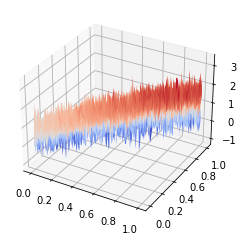

In [16]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


ax.plot_surface(x, t, c3 + noise3, cmap=cm.coolwarm, linewidth=0, antialiased=True)
plt.show()

In [14]:
sols, descr, X, y1, y2, y3 = discover_pde_u(c1, c2, c3, x, t, 6, 3, 9, 1e-2, 1, 4)

for i in range(len(sols)):
    print(return_pde(sols[i]["B"], descr))

1.2162988332552953 1.2529147442093735
1.5865953375593949 1.6294475659861594
0.3769778940189613 0.3836974322788996
Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  4
u_t = (0.348757)c2
u_t = (0.418508)c2 + (0.238357)c3c2_{x}
u_t = (1.829763) + (-2.172676)c3_{x} + (-1.057910)c3 + (0.502210)c2


In [ ]:
Xp = np.array([X[:, 0], X[:, 10], X[:, 11], X[:, 18], X[:, 32]])
y1 = y1.reshape(len(y1), 1)
Xp.shape

In [15]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(Xp.T, y1)
y1pred = model.predict(Xp.T)
r2_score(y1, y1pred)

0.941181833693892

In [16]:
Z = np.hstack([X[:, 1:], np.reshape(y1, (len(y1), 1)), np.reshape(y2, (len(y2), 1)), np.reshape(y3, (len(y3), 1))])
Zs = Z - np.mean(Z, axis=0, keepdims=True)
u, s, v = np.linalg.svd(Zs, full_matrices=False)
np.round(s, 4)

array([1.23190063e+06, 8.68420277e+04, 1.25074968e+04, 9.95891320e+03,
       3.43243130e+03, 2.78372040e+03, 7.48247100e+02, 5.40036100e+02,
       3.96709700e+02, 3.33378700e+02, 1.09857400e+02, 8.48929000e+01,
       8.13684000e+01, 7.42770000e+01, 4.39993000e+01, 3.86254000e+01,
       2.16306000e+01, 1.61610000e+01, 4.34540000e+00, 3.12250000e+00,
       1.51010000e+00, 1.38410000e+00, 8.53200000e-01, 7.91600000e-01,
       4.81500000e-01, 3.32600000e-01, 1.98000000e-01, 2.59000000e-02,
       1.96000000e-02, 1.43000000e-02, 7.40000000e-03, 5.60000000e-03,
       4.00000000e-04, 2.00000000e-04, 2.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

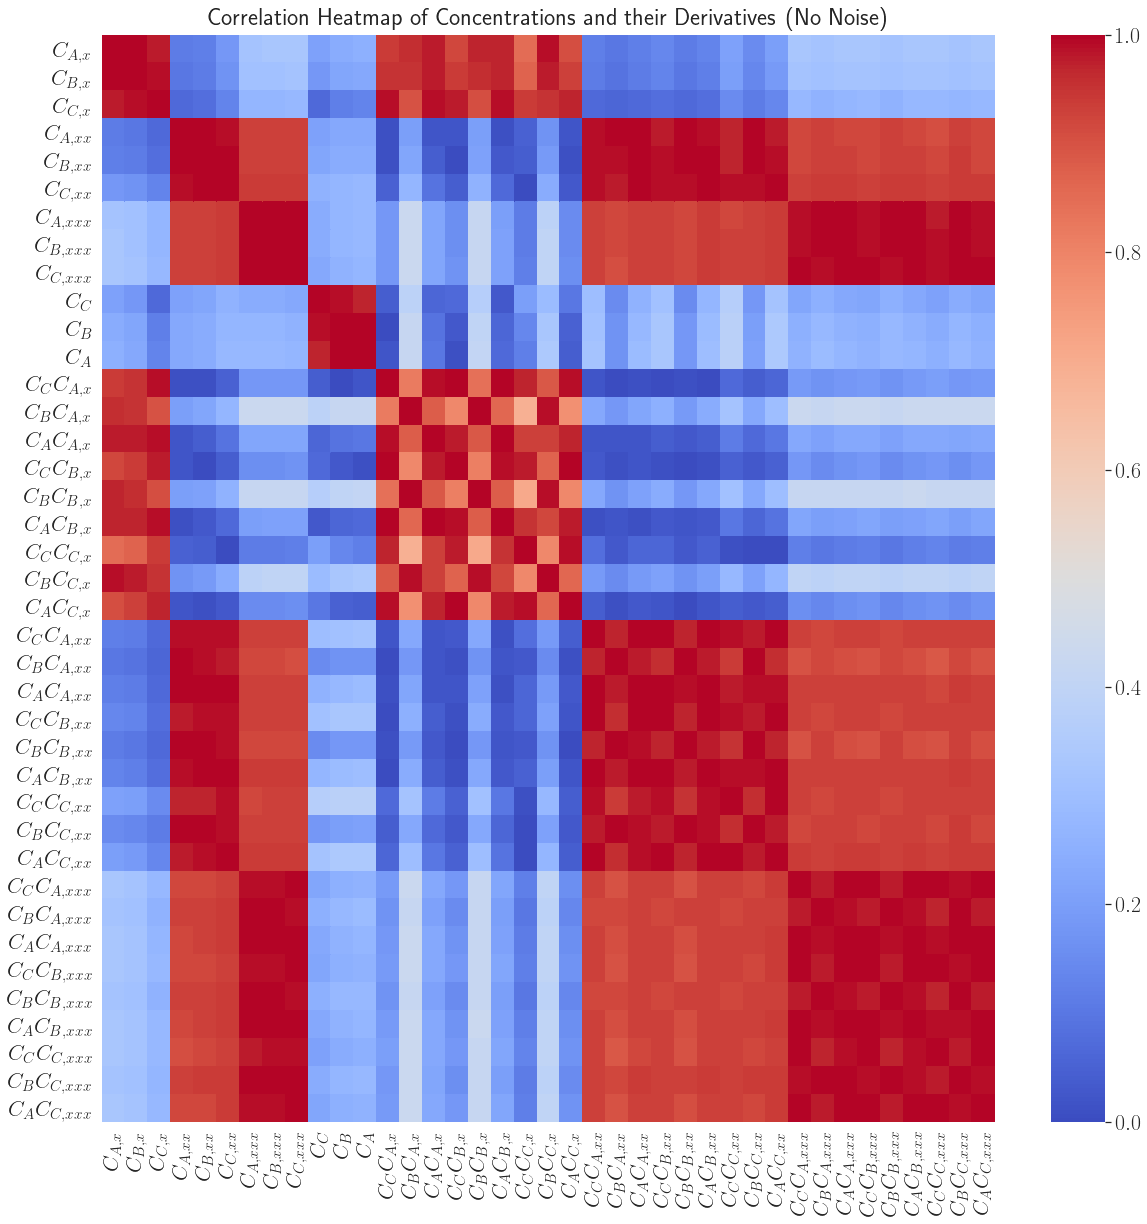

In [59]:
heatplot(X, y1, descr)